### **KNN**



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
classification = pd.read_csv('https://raw.githubusercontent.com/morn12/tb/main/190%20(1).csv',parse_dates=['Date'])
classification.drop(['Date', 'Hour','SMP','Unnamed: 0'], axis=1, inplace=True)
classification


,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,24.47,0,1,0,0,0,0
1,24.30,0,1,0,0,0,0
2,24.17,0,1,0,0,0,0
3,23.99,0,1,0,0,0,0
4,23.93,0,1,0,0,0,0
...,...,...,...,...,...,...,...
30708,12.26,0,0,0,0,0,0
30709,12.27,0,0,0,0,0,0
30710,12.06,0,0,0,0,0,0
30711,12.06,0,0,0,0,0,0


## EDA

In [3]:
counts = classification.SMP_Above_190.value_counts()
percentage = [str(round(i/counts.sum()*100,2)) +'%' for i in counts]
percentage 

['89.83%', '10.17%']

In [4]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Low SMP', 'High SMP'],
    y=counts,
    marker_color=['PALEGREEN','YELLOW'],
    text=percentage,
    textposition='outside',
))
fig.update_layout(
    width=600,
    title='The SMP Level', 
    yaxis_title='Number of cases',
    )
fig.show()

## Up Sampling & Down Sampling - איזון עמודת המטרה

In [5]:
# ספירת כמויות של 0 ו - 1 בעמודת המטרה
count_class_0, count_class_1 = classification.SMP_Above_190.value_counts()

# חלוקה למחלקות של 0 ו - 1
df_class_0 = classification[classification['SMP_Above_190'] == 0]
df_class_1 = classification[classification['SMP_Above_190'] == 1]

In [6]:
df_class_1_over = df_class_1.sample((count_class_1 * 3),replace=True) 
df_class_0_under = df_class_0.sample(count_class_1 * 3)

# ניפוח המחלקה הקטנה פי 3, ולאחר מכן לקיחת מחלקה רנדומלית מהמחלקה הגדולה שהיא בגודל
# המחלקה הקטנה החדשה

df_balanced = pd.concat([df_class_0_under, df_class_1_over], axis=0)
print('Random under-sampling:')
print(df_balanced.SMP_Above_190.value_counts())

Random under-sampling:
0    9375
1    9375
Name: SMP_Above_190, dtype: int64


In [7]:
df_balanced.reset_index(drop=True, inplace= True)
df_balanced

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,25.56,0,1,0,0,0,0
1,10.91,0,0,0,0,0,0
2,25.17,1,0,0,0,0,0
3,21.29,1,0,0,0,0,0
4,18.26,0,0,0,0,0,0
...,...,...,...,...,...,...,...
18745,25.27,0,0,0,0,0,1
18746,25.07,0,1,0,0,0,1
18747,27.91,1,0,0,0,0,1
18748,22.53,0,0,1,0,0,1


## מפת חום וקורלציה

In [8]:
corr_df = df_balanced.corr()
corr_df

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
Temp,1.000000,-0.021533,0.477326,-0.030203,-0.339574,0.422529,0.471600
Is_Holiday,-0.021533,1.000000,-0.242068,-0.044899,-0.039870,-0.098748,0.042222
Is_Vac,0.477326,-0.242068,1.000000,0.028733,-0.109061,0.302911,0.282228
Is_Weekend,-0.030203,-0.044899,0.028733,1.000000,0.051947,-0.065335,-0.032254
Is_Cold,-0.339574,-0.039870,-0.109061,0.051947,1.000000,-0.069145,-0.088789
Is_HW,0.422529,-0.098748,0.302911,-0.065335,-0.069145,1.000000,0.142283
SMP_Above_190,0.471600,0.042222,0.282228,-0.032254,-0.088789,0.142283,1.000000


In [9]:
fig = go.Figure()
fig.add_traces(go.Heatmap(
    z=corr_df, 
    x=corr_df.columns, 
    y=corr_df.columns,
    zmax=1, 
    zmin=-1
))
fig.update_layout({
    'title':"Features Correlation Heatmap"
})

# נרמול עמודת הטמפרטורה

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_balanced[['Temp']]), columns=['Scaled_Temp'])
scaled_df.head()

,Scaled_Temp
0,0.637668
1,0.190476
2,0.625763
3,0.507326
4,0.414835


In [11]:
df_balanced.drop(['Temp'],axis=1, inplace=True)
scaled_df = pd.merge(left=scaled_df, right=df_balanced,left_index=True, right_index=True)
scaled_df.head()

,Scaled_Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,0.637668,0,1,0,0,0,0
1,0.190476,0,0,0,0,0,0
2,0.625763,1,0,0,0,0,0
3,0.507326,1,0,0,0,0,0
4,0.414835,0,0,0,0,0,0


In [12]:
X = scaled_df.drop('SMP_Above_190', axis=1)
y = scaled_df.SMP_Above_190

# Feature importance

In [13]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X,y)
feat_importances_df = pd.DataFrame({'feature_importance':model.feature_importances_}, index=X.columns)
feat_importances_df.sort_values(by='feature_importance', ascending=False)
# מאחר ואין לנו הרבה פיצרים בחרנו להשאיר את כולם

,feature_importance
Scaled_Temp,0.393616
Is_HW,0.204545
Is_Vac,0.124789
Is_Holiday,0.119139
Is_Weekend,0.096763
Is_Cold,0.061147


In [14]:
from sklearn.feature_selection import SelectKBest , chi2

chi_selector = SelectKBest(chi2, k =len(X.columns))
chi_selector.fit(X, y)

scores = pd.Series(chi_selector.scores_.tolist()) 
p_values = round(pd.Series(chi_selector.pvalues_.tolist()), 4) 
selected_df = pd.DataFrame({'univariate_score':scores, 'p_values':p_values})
selected_df.set_index(X.columns, inplace=True, drop=True)
univariate = selected_df.sort_values(by='univariate_score', ascending=False)
univariate
# מאחר ואין לנו הרבה פיצרים בחרנו להשאיר את כולם

,univariate_score,p_values
Is_Vac,1030.781374,0.0000
Is_HW,321.563154,0.0000
Scaled_Temp,295.716825,0.0000
Is_Cold,144.000000,0.0000
Is_Holiday,29.565358,0.0000
Is_Weekend,14.144354,0.0002


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
train_df.head(10)

,Scaled_Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
1016,0.263736,0,0,1,0,0,0
12440,0.579060,0,1,0,0,1,1
15853,0.593407,1,0,0,0,0,1
943,0.633700,0,0,1,0,0,0
15857,0.388889,0,0,0,0,0,1
15913,0.731380,0,1,0,0,0,1
5668,0.230769,1,0,1,0,0,0
13766,0.553419,0,0,0,0,0,1
3272,0.360195,0,0,0,0,0,0
4666,0.189866,0,0,0,0,0,0


# KNN מודל

In [16]:
from sklearn.neighbors import KNeighborsClassifier

###בחירת מספר שכנים

In [17]:
import numpy as np
error_rate = []
for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [18]:
trace = go.Scatter(
    x=[i for i in range(1,60)],
    y=error_rate,
    mode='markers+lines', 
)
fig = go.Figure(trace)
fig.update_layout(
    title='Error by K Value', 
    xaxis_title='k neighboors',
    yaxis_title='Error rate'
)

fig.show()

In [19]:
# בעזרת הגרף בחרנו לקחת מספר שכנים שווה ל - 1
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [20]:
prediction = knn.predict(X_train)

In [21]:
y_train_pred = pd.Series(prediction, name='prediction', index=y_train.index)

train_results = pd.DataFrame(data={'prediction':y_train_pred, 'actual':y_train})
train_results # תוצאות החיזויים על סט המבחן

,prediction,actual
1016,0,0
12440,1,1
15853,1,1
943,0,0
15857,1,1
...,...,...
8222,0,0
9449,1,1
8471,0,0
17048,1,1


### חיזוי והערכת המודל

In [22]:
len_correct_rows = len(train_results.loc[train_results.prediction==train_results.actual])
accuracy = round(len_correct_rows/len(train_results),3)
print('accuracy = ', accuracy)

from sklearn import metrics
accu = metrics.accuracy_score(y_train, y_train_pred)
accu # רמת דיוק גבוה מאוד

accuracy =  0.869


0.8694857142857143

In [23]:
#Test

y_pred = knn.predict(X_test)

y_test_pred = pd.Series(y_pred, name='prediction', index=y_test.index)

test_results = pd.DataFrame(data={'prediction':y_test_pred, 'actual':y_test})
test_results

,prediction,actual
9878,0,1
15010,1,1
9630,1,1
16150,0,1
13141,1,1
...,...,...
4764,0,0
2793,0,0
5812,0,0
15993,0,1


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0

[[2070  730]
 [ 502 2323]]


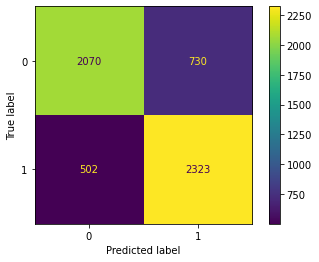

In [25]:
disp = ConfusionMatrixDisplay(confusion, display_labels=knn.classes_)
disp.plot()

In [26]:
print(classification_report(y_test, y_pred))
print('accuracy:',accu)
# F1 מדדי
# מאוד טובים, מה שמראה על מודל מעולה

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2800
           1       0.76      0.82      0.79      2825

    accuracy                           0.78      5625
   macro avg       0.78      0.78      0.78      5625
weighted avg       0.78      0.78      0.78      5625

accuracy: 0.8694857142857143


# ללא פיצר של טמפרטורה KNN מודל

In [27]:
without_HM = df_balanced.copy()
without_HM

,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,0,1,0,0,0,0
1,0,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
18745,0,0,0,0,0,1
18746,0,1,0,0,0,1
18747,1,0,0,0,0,1
18748,0,0,1,0,0,1


In [28]:
X = without_HM.drop('SMP_Above_190', axis=1)
y = without_HM.SMP_Above_190

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
train_df.head(10)

,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
1016,0,0,1,0,0,0
12440,0,1,0,0,1,1
15853,1,0,0,0,0,1
943,0,0,1,0,0,0
15857,0,0,0,0,0,1
15913,0,1,0,0,0,1
5668,1,0,1,0,0,0
13766,0,0,0,0,0,1
3272,0,0,0,0,0,0
4666,0,0,0,0,0,0


In [30]:
from sklearn.neighbors import KNeighborsClassifier

###בחירת מספר שכנים

In [31]:
import numpy as np
error_rate = []
for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [32]:
trace = go.Scatter(
    x=[i for i in range(1,60)],
    y=error_rate,
    mode='markers+lines', 
)
fig = go.Figure(trace)
fig.update_layout(
    title='Error by K Value', 
    xaxis_title='k neighboors',
    yaxis_title='Error rate'
)

fig.show()

In [39]:
#בעזרת הגרף בחרנו 25 כמספר השכנים
knn = KNeighborsClassifier(n_neighbors = 25)
knn.fit(X_train, y_train)
prediction = knn.predict(X_train)

In [40]:
y_train_pred = pd.Series(prediction, name='prediction', index=y_train.index)

train_results = pd.DataFrame(data={'prediction':y_train_pred, 'actual':y_train})
train_results

,prediction,actual
1016,0,0
12440,1,1
15853,1,1
943,0,0
15857,0,1
...,...,...
8222,0,0
9449,1,1
8471,0,0
17048,1,1


##חיזוי והערכת המודל

In [41]:
len_correct_rows = len(train_results.loc[train_results.prediction==train_results.actual])
accuracy = round(len_correct_rows/len(train_results),3)
print('accuracy = ', accuracy)

from sklearn import metrics
accu = metrics.accuracy_score(y_train, y_train_pred)
accu
# מאחר ופיצר הטמפרטורה מאוד משמעותי, רמת הדיוק ירדה בהרבה

accuracy =  0.662


0.6624

In [42]:
#Test
y_pred = knn.predict(X_test)
y_test_pred = pd.Series(y_pred, name='prediction', index=y_test.index)

test_results = pd.DataFrame(data={'prediction':y_test_pred, 'actual':y_test})
test_results

,prediction,actual
9878,1,1
15010,1,1
9630,0,1
16150,0,1
13141,1,1
...,...,...
4764,0,0
2793,0,0
5812,0,0
15993,1,1


[[1938  862]
 [1056 1769]]


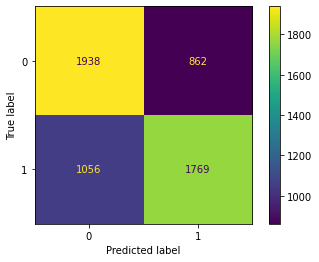

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
disp = ConfusionMatrixDisplay(confusion, display_labels=knn.classes_)
disp.plot()
# לעומת המודל הקודם, כאן ניתן לראות שהוא חזק יותר בחיזוי של 0 מאשר חיזוי על 1

In [44]:
print(classification_report(y_test, y_pred))
print('accuracy:',accu)
# כיוון שפיצר הטמפרטורה הוא המשפיע ביותר על המודל, תוצאות המודל הורעו משמעותית לאחר הורדתו

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      2800
           1       0.67      0.63      0.65      2825

    accuracy                           0.66      5625
   macro avg       0.66      0.66      0.66      5625
weighted avg       0.66      0.66      0.66      5625

accuracy: 0.6624
